In [14]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.stats as stats

from get_data import *
from get_financial_data import *
from merge_results import merge as mergedf

In [3]:
def diff_estimate(hash):
    """
     Count the amounts of 0s at the start of a hash to put an upper-bound on the difficulty
     Difficulty reevaluation is every 20160 minutes, so theoretically about 2016 blocks
     Hence, taking the min value of this over 2016 consecutive blocks can gives a reasonable difficulty estimate
     From this we can then reverse-engineer the approximate hashpower of the network 
     (TODO, will do so later)
    """
    return len(hash)-len(hash.lstrip('0'))

def sanitize_height(from_height, to_height):
    """ CQFD """
    if from_height > to_height: from_height, to_height = to_height, from_height
    return max(from_height, 0), min(to_height, getBlockLast()['height'])

def get_value(tx_out):
    """
     Get the total value of a transaction by counting what every output UTXO of the transaction recieves
    """
    return sum([out['value'] for out in tx_out])

def gather_statistics(from_height, to_height, interests, tx_interests):
    """
     gather block information for blocks ranging from from_height to to_height
     interests: statistics gathered (NOT resiliant to change, check code)
     tx_interests: statistics gathered for each transaction (NOT resiliant to change, check code)
     OUTPUT: Pandas DataFrame with data
        columns: the interests then count, mean, std, min, max for each tx_interests
        rows: 1 per block

     Statistics gathered can then be cross examined for possible correlation
     Time taken: 5 blocks per second, seems to be linear
        Limited by web requests (parallelise requests maybe? might hit server limits)
    """
    from_height, to_height = sanitize_height(from_height, to_height)
    interests = interests.split(' ')
    tx_interests = tx_interests.split(' ')
    interests = interests + [a+'_'+b for a in tx_interests for b in 'count mean std min max'.split(' ')]
    block_data = pd.DataFrame(columns=interests, index=range(from_height, to_height))
    #block_data = np.zeros((to_height-from_height, len(interests)))

    for height in range(from_height, to_height):
        block = getBlockN(height)
        
        hash = int(block['hash'], 16)
        difficulty = diff_estimate(block['hash'])

        # interests for the transactions: vin_sz vout_sz fee lock_time value
        transac_data = np.zeros((block['n_tx'], len(tx_interests)))
        for i, tx in enumerate(block['tx']):
            tx_data = [tx[param] for param in tx_interests[:4]]
            value = get_value(tx['out'])
            transac_data[i, :] = tx_data + [value]

        transac_data = pd.DataFrame(transac_data).describe(percentiles=[]).drop(index='50%')
        transac_data = list(transac_data.to_numpy().flatten())
        
        data = [hash] + [block[i] for i in interests[1:7]] + [difficulty] + transac_data
        block_data.loc[height, :] = data
        #block_data[height-from_height, :] = data

    # TODO add time taken to validate block (next_block["time"] - block["time"])
    # look at spread around 10 minutes

    return block_data

In [6]:
from_height, to_height = 0, 50000
interests = 'hash ver time bits fee nonce n_tx difficulty'
tx_interests = 'vin_sz vout_sz fee lock_time value'

block_data = gather_statistics(from_height, to_height, interests, tx_interests)

print('Done')
block_data.to_csv(f"data_btc/blocks_{from_height}_{to_height}.csv")

Done


In [5]:
mergedf(600000, 605000, 1000)

In [6]:
from_height, to_height = 600000, 605000
block_data = pd.read_csv(f"data_btc/blocks_{from_height}_{to_height}.csv", index_col=0)
#block_data.drop(index=range(100), inplace=True)
print(block_data.columns)
block_data

Index(['hash', 'ver', 'time', 'bits', 'fee', 'nonce', 'n_tx', 'difficulty',
       'vin_sz_count', 'vin_sz_mean', 'vin_sz_std', 'vin_sz_min', 'vin_sz_max',
       'vout_sz_count', 'vout_sz_mean', 'vout_sz_std', 'vout_sz_min',
       'vout_sz_max', 'fee_count', 'fee_mean', 'fee_std', 'fee_min', 'fee_max',
       'lock_time_count', 'lock_time_mean', 'lock_time_std', 'lock_time_min',
       'lock_time_max', 'value_count', 'value_mean', 'value_std', 'value_min',
       'value_max'],
      dtype='object')


,hash,ver,time,bits,fee,nonce,n_tx,difficulty,vin_sz_count,vin_sz_mean,vin_sz_std,vin_sz_min,vin_sz_max,vout_sz_count,vout_sz_mean,vout_sz_std,vout_sz_min,vout_sz_max,fee_count,fee_mean,fee_std,fee_min,fee_max,lock_time_count,lock_time_mean,lock_time_std,lock_time_min,lock_time_max,value_count,value_mean,value_std,value_min,value_max
600000,6889523660235612009491330072510689372714345385...,536870912,1571443461,387294044,3764047,1066642855,1925,19,1925.0,1925.0,1925.0,1925.0,1925.0,1.954286,2.140260,1955.349091,3.459713e+04,1.771703e+08,9.767249,4.143485,8394.592991,1.398975e+05,3.446912e+09,1.0,1.0,0.0,0.0,546.0,250.0,177.0,201144.0,6.000000e+05,1.388198e+11
600001,4843281601854676141968251076445330102234680213...,536928256,1571443613,387294044,2442758,224996688,505,20,505.0,505.0,505.0,505.0,505.0,1.714851,2.249505,4837.144554,1.223747e+05,9.031995e+07,3.925127,3.123948,21067.220911,2.420007e+05,4.643927e+08,1.0,1.0,0.0,0.0,1257.0,66.0,63.0,440000.0,6.000010e+05,5.734118e+09
600002,2171779888300461988536058097868347873505187954...,541065216,1571444075,387294044,7969178,2959103541,1842,19,1842.0,1842.0,1842.0,1842.0,1842.0,1.478284,2.182953,4326.372421,8.599300e+04,1.662484e+08,4.415889,2.386289,12901.107742,2.102968e+05,2.190971e+09,1.0,1.0,0.0,0.0,2163.0,121.0,61.0,234311.0,6.000020e+05,6.278906e+10
600003,1209504840448345867019064409169637081031173628...,536928256,1571445548,387294044,21563110,1245319653,3339,19,3339.0,3339.0,3339.0,3339.0,3339.0,1.638814,2.378556,6457.954477,2.715587e+05,7.412111e+08,5.307851,4.742043,31888.820867,9.421117e+06,8.419436e+09,1.0,1.0,0.0,0.0,1261.0,156.0,164.0,1641040.0,5.443355e+08,1.476863e+11
600004,1175547074934595298740718359204164837795952871...,770416640,1571446016,387294044,11551321,1687052897,2557,19,2557.0,2557.0,2557.0,2557.0,2557.0,1.691044,2.112241,4517.528745,5.823218e+04,3.566157e+08,7.401358,1.362473,31257.012337,1.775979e+05,5.666375e+09,1.0,1.0,0.0,0.0,0.0,195.0,41.0,1391269.0,6.000040e+05,1.381061e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604995,6978251755479703726350468086255920538292889014...,1073676288,1574474610,387297854,14763856,2471136176,2006,20,2006.0,2006.0,2006.0,2006.0,2006.0,2.011466,2.202393,7359.848455,1.007706e+05,3.736706e+08,8.238125,1.755622,50959.921245,2.253986e+05,3.861771e+09,1.0,1.0,0.0,0.0,546.0,240.0,44.0,2122080.0,6.049950e+05,9.614253e+10
604996,1444599432692818626800844884870377283700701505...,536870912,1574474749,387297854,3412383,1482564189,525,19,525.0,525.0,525.0,525.0,525.0,1.539048,2.211429,6499.777143,4.252796e+06,3.411133e+08,3.148503,2.398127,43351.986986,9.566718e+07,4.427406e+09,1.0,1.0,0.0,0.0,546.0,64.0,52.0,944160.0,2.192083e+09,1.000000e+11
604997,3042548119370051535529496091429256707688824870...,541065216,1574475806,387297854,26221179,1096475807,2548,19,2548.0,2548.0,2548.0,2548.0,2548.0,1.778650,4.817111,10290.886578,7.411947e+05,5.850286e+08,7.428898,57.596272,70767.369606,2.294671e+07,5.948333e+09,1.0,1.0,0.0,0.0,546.0,240.0,1702.0,2122080.0,1.025898e+09,2.657357e+11
604998,1827898511744663756201707195123412533526774618...,536870912,1574476116,387297854,8713765,1964228899,1519,18,1519.0,1519.0,1519.0,1519.0,1519.0,1.701119,2.971034,5736.514154,6.896900e+04,1.803595e+08,7.768145,25.444827,56892.838654,1.922503e+05,1.697422e+09,1.0,1.0,0.0,0.0,546.0,240.0,940.0,2122080.0,6.049980e+05,4.000567e+10


In [144]:
block_data["time_diff"] = [b-a for a,b in zip(block_data["time"][:-1], block_data["time"][1:])] + [0]
block_data['date'] = pd.to_datetime(block_data['time'], unit='s')

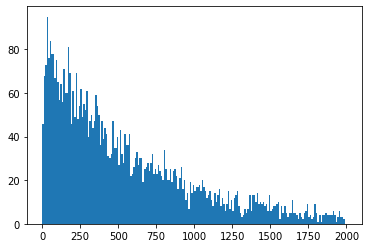

In [8]:
plt.hist(block_data["time_diff"], bins=200, range=(0,2000))
#plt.xscale("log")
plt.show()

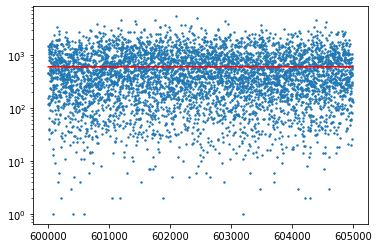

In [9]:
plt.scatter(block_data.index, block_data["time_diff"], s=2)
plt.plot(block_data.index, [10*60 for _ in block_data.index], c='r')
plt.yscale("log")

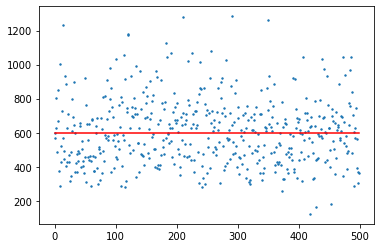

In [27]:
bins = len(block_data)//10
grouped = block_data["time_diff"].groupby(np.arange(len(block_data))//10).mean()
plt.scatter(grouped.index, grouped, s=2)
plt.plot(grouped.index, [10*60 for _ in grouped.index], c='r')
#plt.yscale("log")

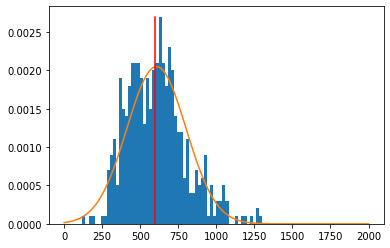

In [67]:
columns, x, _ = plt.hist(grouped, bins=100, range=(0,2000), density=True)

mean = grouped.mean()
std  = grouped.std()
#x = np.linspace(0, 2000, 1000)
plt.plot(x, stats.norm.pdf(x, mean, std))

#plt.xscale("log")
plt.plot([600,600],[0,columns.max()],c='r')
plt.show()

In [130]:
financial = get_ticker_data('btc-usd')
financial.columns

Shape of DataFrame:  (2603, 7)


Index(['date', 'open', 'high', 'low', 'close', 'volume', 'day'], dtype='object')

In [131]:
block_data.columns

Index(['hash', 'ver', 'time', 'bits', 'fee', 'nonce', 'n_tx', 'difficulty',
       'vin_sz_count', 'vin_sz_mean', 'vin_sz_std', 'vin_sz_min', 'vin_sz_max',
       'vout_sz_count', 'vout_sz_mean', 'vout_sz_std', 'vout_sz_min',
       'vout_sz_max', 'fee_count', 'fee_mean', 'fee_std', 'fee_min', 'fee_max',
       'lock_time_count', 'lock_time_mean', 'lock_time_std', 'lock_time_min',
       'lock_time_max', 'value_count', 'value_mean', 'value_std', 'value_min',
       'value_max', 'time_diff', 'date'],
      dtype='object')

In [135]:
financial.drop(inplace=True, index=np.where(financial['date']<block_data['date'][block_data.index[0]])[0])
financial.reset_index(inplace=True)
financial.drop(inplace=True, index=np.where(financial['date']>block_data['date'][block_data.index[-1]])[0])

In [136]:
financial.shape

(35, 9)

In [170]:
def plot_with_financial(col):
    grouped = block_data.groupby(np.arange(len(block_data))//40).mean()
    grouped['date'] = pd.to_datetime(grouped['time'], unit='s')

    fig,ax=plt.subplots()
    ax.plot(financial['date'], financial['close'], color='purple', linewidth=5)
    ax.set_xlabel("time")
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylabel("value (USD)", color='purple')

    ax2=ax.twinx()
    ax2.plot(grouped['date'], grouped[col], color='blue', alpha=.8)
    ax2.set_ylabel(col,color="blue",fontsize=14)

    plt.show()

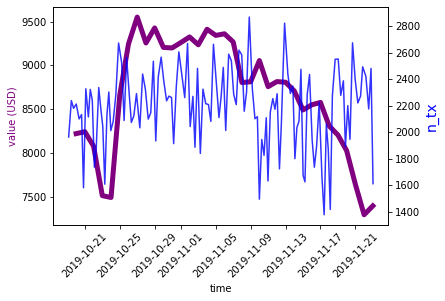

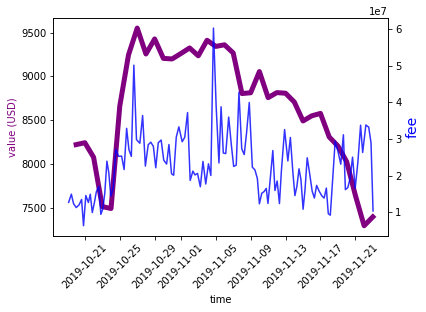

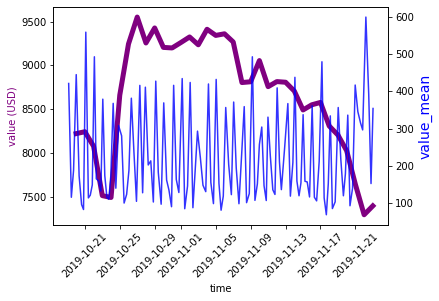

In [171]:
plot_with_financial('n_tx')
plot_with_financial('fee')
plot_with_financial('value_mean')

In [145]:
grouped = block_data.groupby(np.arange(len(block_data))//10).mean()
grouped.columns

Index(['ver', 'time', 'bits', 'fee', 'nonce', 'n_tx', 'difficulty',
       'vin_sz_count', 'vin_sz_mean', 'vin_sz_std', 'vin_sz_min', 'vin_sz_max',
       'vout_sz_count', 'vout_sz_mean', 'vout_sz_std', 'vout_sz_min',
       'vout_sz_max', 'fee_count', 'fee_mean', 'fee_std', 'fee_min', 'fee_max',
       'lock_time_count', 'lock_time_mean', 'lock_time_std', 'lock_time_min',
       'lock_time_max', 'value_count', 'value_mean', 'value_std', 'value_min',
       'value_max', 'time_diff'],
      dtype='object')

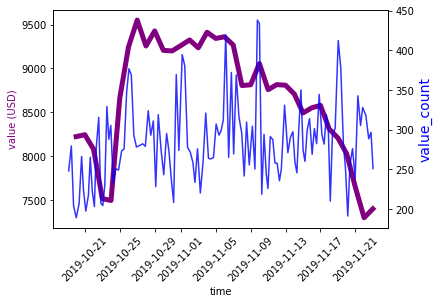

In [172]:
plot_with_financial('value_count')